# Semester Project: Endangered Species Across the United States

### Loading Packages and Datasets

In [322]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import chi2_contingency
from sklearn import neighbors

In [2]:
parks = pd.read_csv(r"C:\Users\datre\OneDrive\Documents\Graduate School\Winter '20\parks.csv")
species = pd.read_csv(r"C:\Users\datre\OneDrive\Documents\Graduate School\Winter '20\species.csv")

C:\Users\datre\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Data Wrangling

In [3]:
# Looking at shape of park dataset
print(parks.shape)
parks.head(3)

(56, 6)


,Park Code,Park Name,State,Acres,Latitude,Longitude
0,ACAD,Acadia National Park,ME,47390,44.35,-68.21
1,ARCH,Arches National Park,UT,76519,38.68,-109.57
2,BADL,Badlands National Park,SD,242756,43.75,-102.50


In [4]:
# Looking at shape of species dataset
print(species.shape)
species.head(3)

(119248, 14)


,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,Unnamed: 13
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,NaN,NaN
1,ACAD-1001,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,NaN,NaN,NaN
2,ACAD-1002,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,NaN,Species of Concern,NaN


In [5]:
# Merging on park name to overlay state, acres, and latitude/longitude
sp = pd.merge(parks, species, on="Park Name")
print(sp.shape)
sp.head()

(119248, 19)


,Park Code,Park Name,State,Acres,Latitude,Longitude,Species ID,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,Unnamed: 13
0,ACAD,Acadia National Park,ME,47390,44.35,-68.21,ACAD-1000,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,NaN,NaN
1,ACAD,Acadia National Park,ME,47390,44.35,-68.21,ACAD-1001,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,NaN,NaN,NaN
2,ACAD,Acadia National Park,ME,47390,44.35,-68.21,ACAD-1002,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,NaN,Species of Concern,NaN
3,ACAD,Acadia National Park,ME,47390,44.35,-68.21,ACAD-1003,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,NaN,NaN,Endangered,NaN
4,ACAD,Acadia National Park,ME,47390,44.35,-68.21,ACAD-1004,Mammal,Carnivora,Canidae,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Approved,Present,Unknown,Common,Breeder,NaN,NaN


In [6]:
# Taking out non-final conservation status such as proposed or unknown
sp_danger = sp[sp["Conservation Status"].isin(["Endangered", "Threatened","In Recovery", "Species of Concern"])]
print(sp_danger.shape)
sp_danger.head(3)

(4478, 19)


,Park Code,Park Name,State,Acres,Latitude,Longitude,Species ID,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,Unnamed: 13
2,ACAD,Acadia National Park,ME,47390,44.35,-68.21,ACAD-1002,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,NaN,Species of Concern,NaN
3,ACAD,Acadia National Park,ME,47390,44.35,-68.21,ACAD-1003,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,NaN,NaN,Endangered,NaN
20,ACAD,Acadia National Park,ME,47390,44.35,-68.21,ACAD-1020,Mammal,Chiroptera,Vespertilionidae,Eptesicus fuscus,"Big Brown Bat, Common Brown Bat",Approved,Present,Native,Uncommon,NaN,Species of Concern,NaN


For consistency, I chose the conservation status rows that have a definite label, versus NaN or proposed labels.

In [7]:
# Examining the labels and types of data in dataset
sp_danger.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4478 entries, 2 to 118992
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Park Code            4478 non-null   object 
 1   Park Name            4478 non-null   object 
 2   State                4478 non-null   object 
 3   Acres                4478 non-null   int64  
 4   Latitude             4478 non-null   float64
 5   Longitude            4478 non-null   float64
 6   Species ID           4478 non-null   object 
 7   Category             4478 non-null   object 
 8   Order                4473 non-null   object 
 9   Family               4473 non-null   object 
 10  Scientific Name      4478 non-null   object 
 11  Common Names         4478 non-null   object 
 12  Record Status        4478 non-null   object 
 13  Occurrence           4254 non-null   object 
 14  Nativeness           4218 non-null   object 
 15  Abundance            3427 non-null  

Off of knowledge, features we will not need in the project include: Park Code, Species ID, Order, Family, Common Names, Record Status, Seasonality, and Unnammed: 13.

In [8]:
# Taking out featuers that are redundant
sp = sp_danger[["Park Name", "State", "Acres", "Latitude", "Longitude", "Category", "Occurrence", "Nativeness", "Conservation Status"]]
sp

,Park Name,State,Acres,Latitude,Longitude,Category,Occurrence,Nativeness,Conservation Status
2,Acadia National Park,ME,47390,44.35,-68.21,Mammal,Present,Not Native,Species of Concern
3,Acadia National Park,ME,47390,44.35,-68.21,Mammal,Not Confirmed,Native,Endangered
20,Acadia National Park,ME,47390,44.35,-68.21,Mammal,Present,Native,Species of Concern
21,Acadia National Park,ME,47390,44.35,-68.21,Mammal,Present,Native,Species of Concern
24,Acadia National Park,ME,47390,44.35,-68.21,Mammal,Present,Native,Species of Concern
...,...,...,...,...,...,...,...,...,...
118628,Zion National Park,UT,146598,37.30,-113.05,Vascular Plant,Not Present (False Report),Native,Species of Concern
118840,Zion National Park,UT,146598,37.30,-113.05,Vascular Plant,Present,Native,Species of Concern
118855,Zion National Park,UT,146598,37.30,-113.05,Vascular Plant,Present,Native,Species of Concern
118894,Zion National Park,UT,146598,37.30,-113.05,Vascular Plant,Present,Native,Species of Concern


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

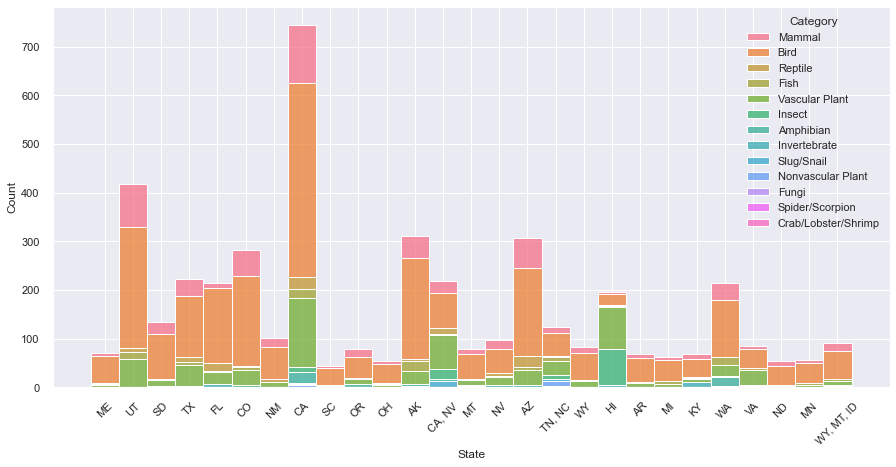

In [9]:
sns.set(style = "darkgrid")
sns.set_palette("hls", 3)
# Setting figure size
plt.figure(figsize=(15,7))
# Using stack to combine categories and see total number of species per state
g1 = sns.histplot(data = sp_danger, x = "State", hue = "Category", multiple = "stack")
# Rotate labels for ease of reading
plt.setp(g1.get_xticklabels(), rotation=45)

In [10]:
# Creating a mini dataset for each conservation status type to graph easier
end = sp[sp["Conservation Status"].isin(["Endangered"])]
threat = sp[sp["Conservation Status"].isin(["Threatened"])]
recov = sp[sp["Conservation Status"].isin(["In Recovery"])]
SOC = sp[sp["Conservation Status"].isin(["Species of Concern"])]

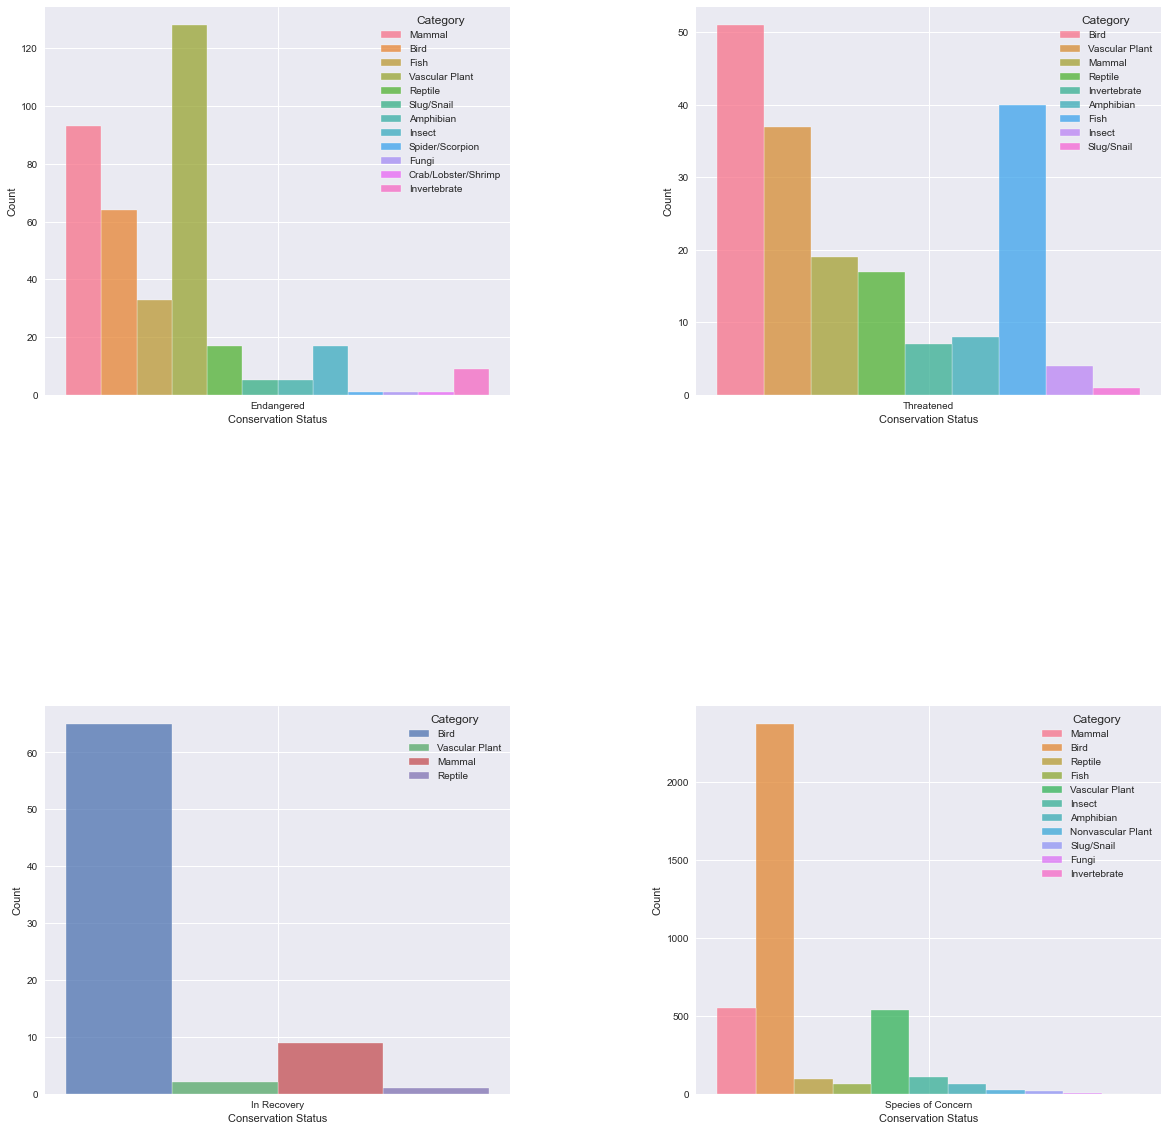

In [11]:
sns.set_palette("hls", 3)
plt.style.use('seaborn')
# asking for two rows and two columns of graphs
fig, axis = plt.subplots(nrows = 2, ncols = 2)
# setting size for graphs
fig.set_size_inches(20,20)
fig.subplots_adjust(wspace = 0.4, hspace = 0.8)

# plot 1
# dodge so bars are next to each other
h1 = sns.histplot(data = end, x = "Conservation Status", hue = "Category", multiple = "dodge", ax = axis[0,0])
# plot 2
h2 = sns.histplot(data = threat, x = "Conservation Status", hue = "Category", multiple = "dodge", ax = axis[0,1])
# plot 3
h3 = sns.histplot(data = recov, x = "Conservation Status", hue = "Category", multiple = "dodge", ax = axis[1,0])
# plot 4
h4 = sns.histplot(data = SOC, x = "Conservation Status", hue = "Category", multiple = "dodge", ax = axis[1,1])

#### Correlation and Heat Map

##### One-Hot Encoding

In [12]:
sp1 = sp.copy()

In [13]:
# creates column for each type in feature to give binomial data
for column in ["Category", "Nativeness"]:
    dummies = pd.get_dummies(sp1[column])
    # adding back to the dataset
    sp1[dummies.columns] = dummies

In [14]:
# seeing the added dummy columns
for col in sp1.columns:
    print(col, ":", len(sp1[col].unique()), "labels")

Park Name : 56 labels
State : 27 labels
Acres : 55 labels
Latitude : 53 labels
Longitude : 55 labels
Category : 13 labels
Occurrence : 6 labels
Nativeness : 4 labels
Conservation Status : 4 labels
Amphibian : 2 labels
Bird : 2 labels
Crab/Lobster/Shrimp : 2 labels
Fish : 2 labels
Fungi : 2 labels
Insect : 2 labels
Invertebrate : 2 labels
Mammal : 2 labels
Nonvascular Plant : 2 labels
Reptile : 2 labels
Slug/Snail : 2 labels
Spider/Scorpion : 2 labels
Vascular Plant : 2 labels
Native : 2 labels
Not Native : 2 labels
Unknown : 2 labels


In [15]:
sp1.head(3)

,Park Name,State,Acres,Latitude,Longitude,Category,Occurrence,Nativeness,Conservation Status,Amphibian,...,Invertebrate,Mammal,Nonvascular Plant,Reptile,Slug/Snail,Spider/Scorpion,Vascular Plant,Native,Not Native,Unknown
2,Acadia National Park,ME,47390,44.35,-68.21,Mammal,Present,Not Native,Species of Concern,0,...,0,1,0,0,0,0,0,0,1,0
3,Acadia National Park,ME,47390,44.35,-68.21,Mammal,Not Confirmed,Native,Endangered,0,...,0,1,0,0,0,0,0,1,0,0
20,Acadia National Park,ME,47390,44.35,-68.21,Mammal,Present,Native,Species of Concern,0,...,0,1,0,0,0,0,0,1,0,0


In [16]:
# taking out the columns that we dummied, as well as occurrence which I felt was not needed
sp1 = sp1.drop(["Category", "Nativeness", "Occurrence"], axis = 1)
sp1.head(3)

,Park Name,State,Acres,Latitude,Longitude,Conservation Status,Amphibian,Bird,Crab/Lobster/Shrimp,Fish,...,Invertebrate,Mammal,Nonvascular Plant,Reptile,Slug/Snail,Spider/Scorpion,Vascular Plant,Native,Not Native,Unknown
2,Acadia National Park,ME,47390,44.35,-68.21,Species of Concern,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,Acadia National Park,ME,47390,44.35,-68.21,Endangered,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
20,Acadia National Park,ME,47390,44.35,-68.21,Species of Concern,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [17]:
# I like to copy the dataset so I don't mess up the original
sp_corr = sp1.copy()
# Creating numerical values for each type of entry in features with categorical data
label_encoder = LabelEncoder()
sp_corr["Park Name"] = label_encoder.fit_transform(sp_corr["Park Name"])
sp_corr["State"] = label_encoder.fit_transform(sp_corr["State"])
sp_corr["Conservation Status"] = label_encoder.fit_transform(sp_corr["Conservation Status"])

In [18]:
corr_matrix = sp_corr.corr()
corr_matrix

,Park Name,State,Acres,Latitude,Longitude,Conservation Status,Amphibian,Bird,Crab/Lobster/Shrimp,Fish,...,Invertebrate,Mammal,Nonvascular Plant,Reptile,Slug/Snail,Spider/Scorpion,Vascular Plant,Native,Not Native,Unknown
Park Name,1.000000,-0.111757,-0.012628,0.227961,-0.189064,0.028289,0.051610,-0.005474,0.009141,0.013780,...,-0.001527,0.026259,0.019621,-0.019615,-0.022755,-0.001883,-0.036952,0.000753,-0.037980,0.043953
State,-0.111757,1.000000,-0.288115,-0.004090,0.308933,0.080314,0.015107,0.013818,-0.004797,0.025182,...,-0.027820,0.024837,0.046635,-0.042112,-0.019977,0.016014,-0.017459,0.097603,-0.053411,-0.039632
Acres,-0.012628,-0.288115,1.000000,0.382716,-0.327344,0.001823,0.008941,-0.039306,-0.007916,0.025835,...,-0.031545,-0.025839,-0.012152,0.010408,0.069785,-0.003159,0.036893,-0.105499,-0.041709,-0.035695
Latitude,0.227961,-0.004090,0.382716,1.000000,-0.250196,0.135262,0.044278,0.127081,-0.002739,0.095829,...,-0.043933,0.042490,0.022015,-0.070895,-0.043225,-0.005235,-0.134650,0.029234,-0.045026,0.018379
Longitude,-0.189064,0.308933,-0.327344,-0.250196,1.000000,0.106659,-0.042402,0.128564,0.019785,-0.021016,...,0.080425,-0.004308,0.046666,0.035440,-0.030691,0.021764,-0.079653,-0.077660,0.079238,0.061806
Conservation Status,0.028289,0.080314,0.001823,0.135262,0.106659,1.000000,0.024683,0.165054,-0.045508,-0.012887,...,-0.051012,-0.081636,0.018282,0.002240,-0.024291,-0.045508,-0.120953,0.058418,0.009461,-0.020874
Amphibian,0.051610,0.015107,0.008941,0.044278,-0.042402,0.024683,1.000000,-0.149144,-0.001937,-0.023201,...,-0.008002,-0.054516,-0.010096,-0.022679,-0.010096,-0.001937,-0.055986,-0.005554,-0.019186,-0.001380
Bird,-0.005474,0.013818,-0.039306,0.127081,0.128564,0.165054,-0.149144,1.000000,-0.017196,-0.205933,...,-0.071027,-0.483888,-0.089612,-0.201301,-0.089612,-0.017196,-0.496935,0.158619,0.013425,-0.006709
Crab/Lobster/Shrimp,0.009141,-0.004797,-0.007916,-0.002739,0.019785,-0.045508,-0.001937,-0.017196,1.000000,-0.002675,...,-0.000923,-0.006285,-0.001164,-0.002615,-0.001164,-0.000223,-0.006455,-0.042883,-0.002212,-0.002574
Fish,0.013780,0.025182,0.025835,0.095829,-0.021016,-0.012887,-0.023201,-0.205933,-0.002675,1.000000,...,-0.011049,-0.075274,-0.013940,-0.031314,-0.013940,-0.002675,-0.077303,-0.045351,0.115751,0.015364


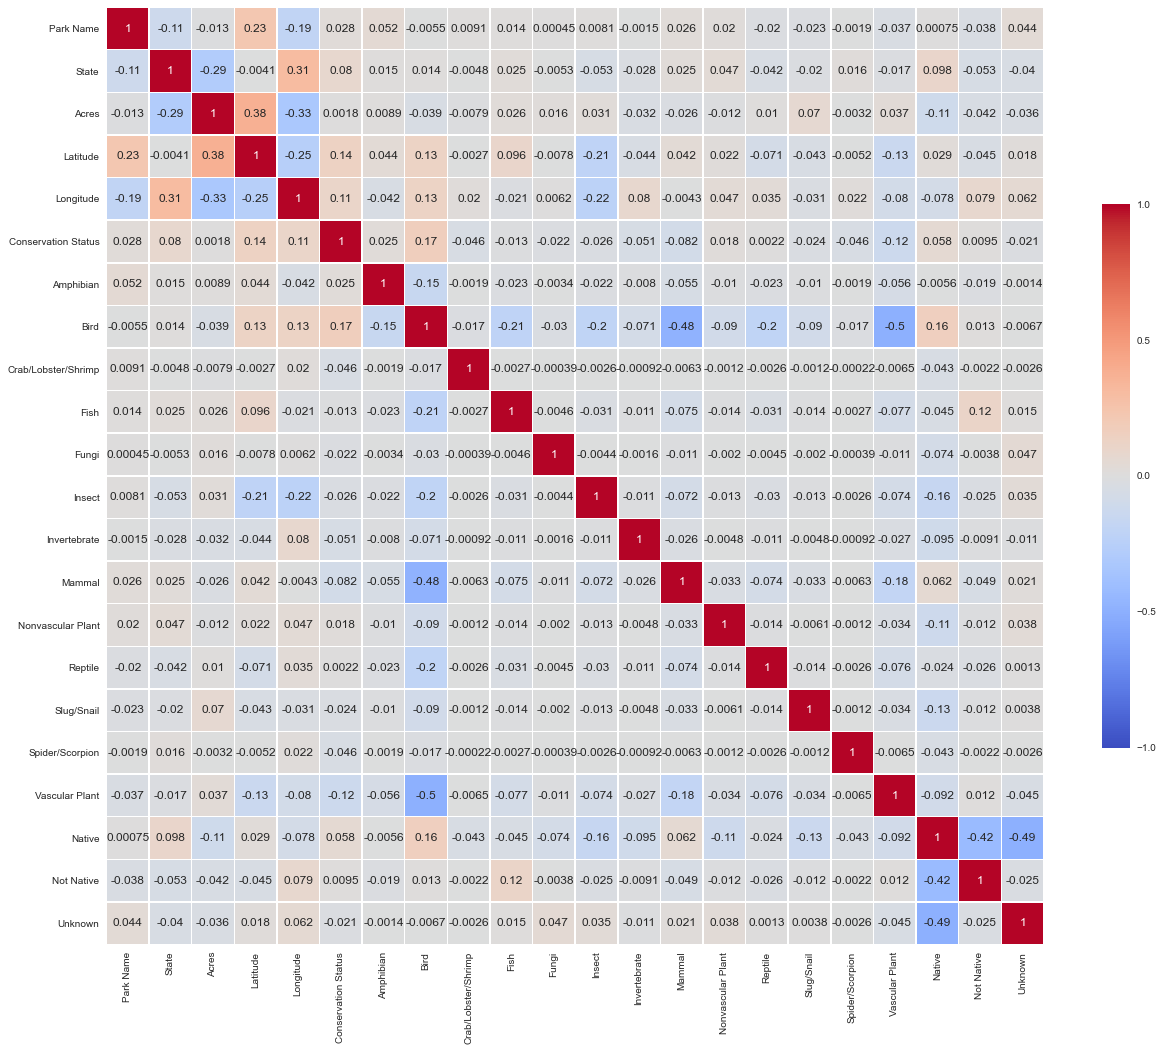

In [19]:
# setting figure size
f, ax = plt.subplots(figsize=(21,25)) 
heatmap = sns.heatmap(corr_matrix,
                      square = True,
                      linewidths = .5,
                      cmap = "coolwarm", # choosing color type for graph
                      cbar_kws = {"shrink": .4, 
                                "ticks" : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

#### Chi-Squared Test

##### H0: Two variables are independent

##### HA: Two variables are not indenpendent

In [20]:
# same as above, copying dataset
sp_cs = sp.copy()
sp_cs.head(3)

,Park Name,State,Acres,Latitude,Longitude,Category,Occurrence,Nativeness,Conservation Status
2,Acadia National Park,ME,47390,44.35,-68.21,Mammal,Present,Not Native,Species of Concern
3,Acadia National Park,ME,47390,44.35,-68.21,Mammal,Not Confirmed,Native,Endangered
20,Acadia National Park,ME,47390,44.35,-68.21,Mammal,Present,Native,Species of Concern


In [21]:
#creating numerical values for categorical data
label_encoder = LabelEncoder()
sp_cs["Park Name"] = label_encoder.fit_transform(sp_cs["Park Name"])
sp_cs["State"] = label_encoder.fit_transform(sp_cs["State"])
sp_cs["Conservation Status"] = label_encoder.fit_transform(sp_cs["Conservation Status"])

In [22]:
#creating binomial data for certain features
for column in ["Category", "Nativeness"]:
    dummies = pd.get_dummies(sp_cs[column])
    sp_cs[dummies.columns] = dummies

In [23]:
#dropping lat and lon because they have negatives, occurrence because not needed, and dummied features
sp_cs = sp_cs.drop(["Latitude", "Longitude", "Occurrence", "Category", "Nativeness"], axis = 1)

In [24]:
sp_cs.head(3)

,Park Name,State,Acres,Conservation Status,Amphibian,Bird,Crab/Lobster/Shrimp,Fish,Fungi,Insect,Invertebrate,Mammal,Nonvascular Plant,Reptile,Slug/Snail,Spider/Scorpion,Vascular Plant,Native,Not Native,Unknown
2,0,9,47390,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,0,9,47390,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
20,0,9,47390,2,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [25]:
# taking out conservation status as variable to compare to all others
X = sp_cs.drop("Conservation Status",axis=1)
y = sp_cs["Conservation Status"]

In [26]:
chi_scores = chi2(X,y)
chi_scores

(array([4.66406416e+01, 2.39688979e+02, 1.21409893e+07, 9.68564916e+00,
        1.57187758e+02, 1.09732620e+01, 2.71458839e+02, 2.54473467e+00,
        6.30035306e+00, 1.10265314e+02, 2.84932001e+01, 4.46135831e+00,
        3.04791781e+01, 4.01990221e+00, 1.09732620e+01, 9.96045964e+01,
        9.44775324e+00, 1.42196182e+01, 5.67884800e+00]),
 array([4.14442865e-10, 1.11112871e-51, 0.00000000e+00, 2.14362146e-02,
        7.41307802e-34, 1.18713400e-02, 1.49226269e-58, 4.67260746e-01,
        9.78775041e-02, 9.62137895e-24, 2.86154886e-06, 2.15763044e-01,
        1.09415314e-06, 2.59323055e-01, 1.18713400e-02, 1.89022191e-21,
        2.38937234e-02, 2.62095610e-03, 1.28324360e-01]))

In [27]:
# pulling out p-values of chi-squared test
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)

<AxesSubplot:>

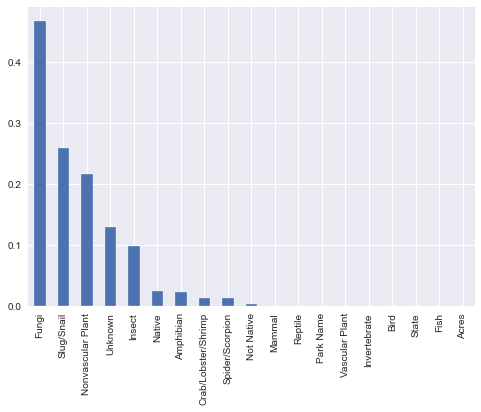

In [28]:
# plotting p-values for ease of understanding and interpretation
p_values.plot.bar()

Since Insect, Unknown, Nonvascular Plant, Slug/Snail, and Fungi have high p-values (above 0.05), they should be removed since they are independent of Conservation Status.

#### Creating dataset for test train splits

In [224]:
# Dropping features from the chi-squared test results that are independent of Conservation Status
sp_tt = sp_cs.drop(["Fungi", "Slug/Snail", "Nonvascular Plant", "Unknown", "Insect"],axis=1)

In [225]:
# Confirming features dropped
print(sp_tt.shape)
sp_tt.head(3)

(4478, 15)


,Park Name,State,Acres,Conservation Status,Amphibian,Bird,Crab/Lobster/Shrimp,Fish,Invertebrate,Mammal,Reptile,Spider/Scorpion,Vascular Plant,Native,Not Native
2,0,9,47390,2,0,0,0,0,0,1,0,0,0,0,1
3,0,9,47390,0,0,0,0,0,0,1,0,0,0,1,0
20,0,9,47390,2,0,0,0,0,0,1,0,0,0,1,0


In [226]:
# Create dataset without target value, conservation status
data_model_x = sp_tt.drop(["Conservation Status"], axis = 1)
data_model_x.head(3)

,Park Name,State,Acres,Amphibian,Bird,Crab/Lobster/Shrimp,Fish,Invertebrate,Mammal,Reptile,Spider/Scorpion,Vascular Plant,Native,Not Native
2,0,9,47390,0,0,0,0,0,1,0,0,0,0,1
3,0,9,47390,0,0,0,0,0,1,0,0,0,1,0
20,0,9,47390,0,0,0,0,0,1,0,0,0,1,0


In [227]:
# The target of this dataset is predicting conservation status
data_model_y = sp_tt["Conservation Status"]
data_model_y.head(3)

2     2
3     0
20    2
Name: Conservation Status, dtype: int32

In [228]:
# Splitting into test and train sets
X_train, X_val, y_train, y_val = train_test_split(data_model_x, data_model_y, test_size =0.3, random_state=11)
print("No. of samples in training set: ", X_train.shape[0])
print("No. of samples in validation set:", X_val.shape[0])

No. of samples in training set:  3134
No. of samples in validation set: 1344


In [229]:
# Stating how many of each conservation level there are
print('\n')
print('No. of each Conservation Status in training set:')
print(y_train.value_counts())

print('\n')
print('No. of each Conservation Status in the validation set:')
print(y_val.value_counts())



No. of each Conservation Status in training set:
2    2693
0     266
3     123
1      52
Name: Conservation Status, dtype: int64


No. of each Conservation Status in the validation set:
2    1150
0     108
3      61
1      25
Name: Conservation Status, dtype: int64


0: Endangered

1: In Recovery

2: Species of Concern  

3: Threatened

#### Perform Logistic Regression Model

In [230]:
# Calling logistic regression model
model = LogisticRegression()

C:\Users\datre\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


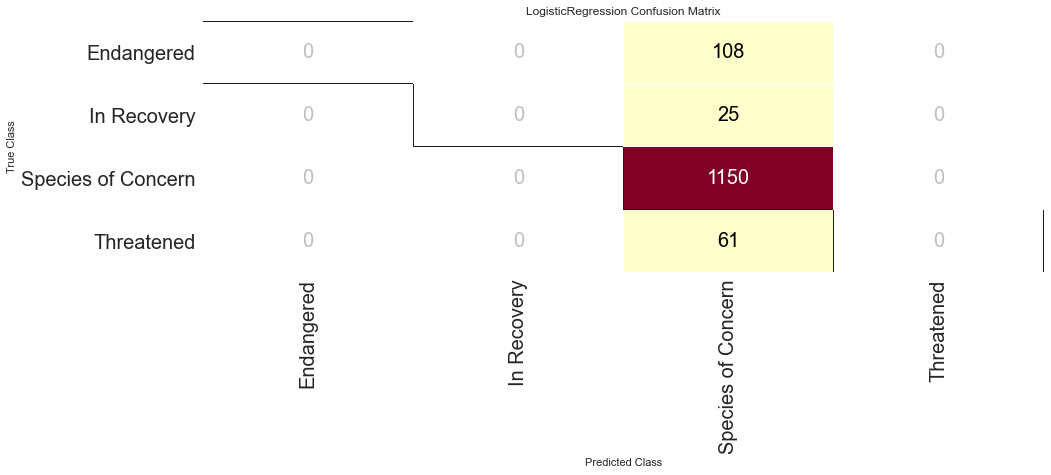

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [231]:
# Taxing model with confushion matrix
classes = ["Endangered", "In Recovery", "Species of Concern", "Threatened"]
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fitting the logistic regression model
cm.fit(X_train, y_train)

# Entering test data into mix
cm.score(X_val, y_val)

# Changing font size
for label in cm.ax.texts:
    label.set_size(20)

cm.poof()

C:\Users\datre\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\datre\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


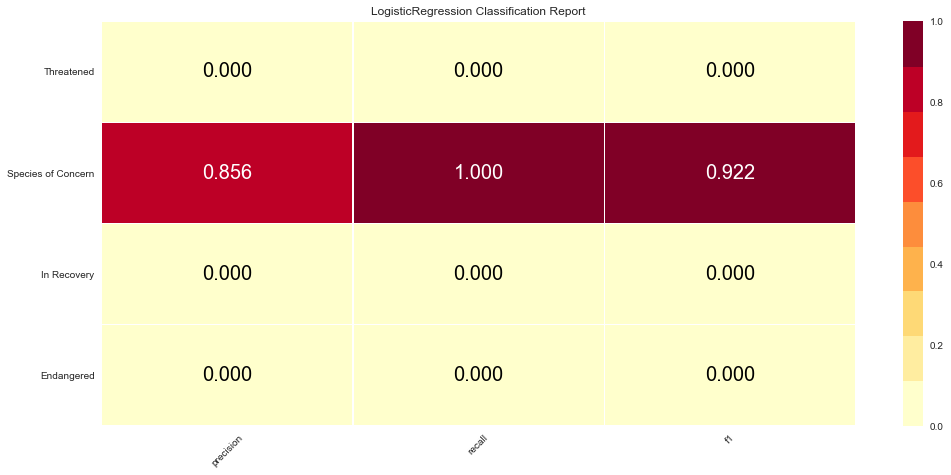

In [232]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

visualizer = ClassificationReport(model, classes=classes)

# Fitting training data to visualizer
visualizer.fit(X_train, y_train)
# Entering test data to model
visualizer.score(X_val, y_val) 

g = visualizer.poof()


C:\Users\datre\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


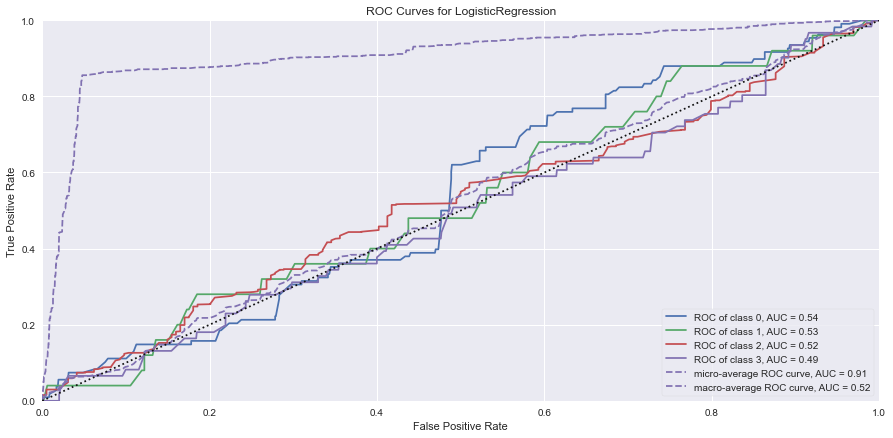

In [233]:
visualizer = ROCAUC(model)

# Fitting training data to visualizer
visualizer.fit(X_train, y_train)
# Entering test data to model
visualizer.score(X_val, y_val) 

g = visualizer.poof()

#### Performing Random Forest Model

In [234]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, bootstrap=True)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [239]:
# Creating predictions
y_pred = rf.predict(X_val)

In [242]:
# Printing the confusion matrix, report, and accuracy to examine before visualizing
print(confusion_matrix(y_val,y_pred))
print(classification_report(y_val,y_pred))
print(accuracy_score(y_val, y_pred))

[[  45    0   60    3]
 [   1    0   24    0]
 [  23    1 1124    2]
 [   5    0   45   11]]
              precision    recall  f1-score   support

           0       0.61      0.42      0.49       108
           1       0.00      0.00      0.00        25
           2       0.90      0.98      0.94      1150
           3       0.69      0.18      0.29        61

    accuracy                           0.88      1344
   macro avg       0.55      0.39      0.43      1344
weighted avg       0.85      0.88      0.85      1344

0.8779761904761905


Accuracy of this prediction model is 87.79%

C:\Users\datre\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


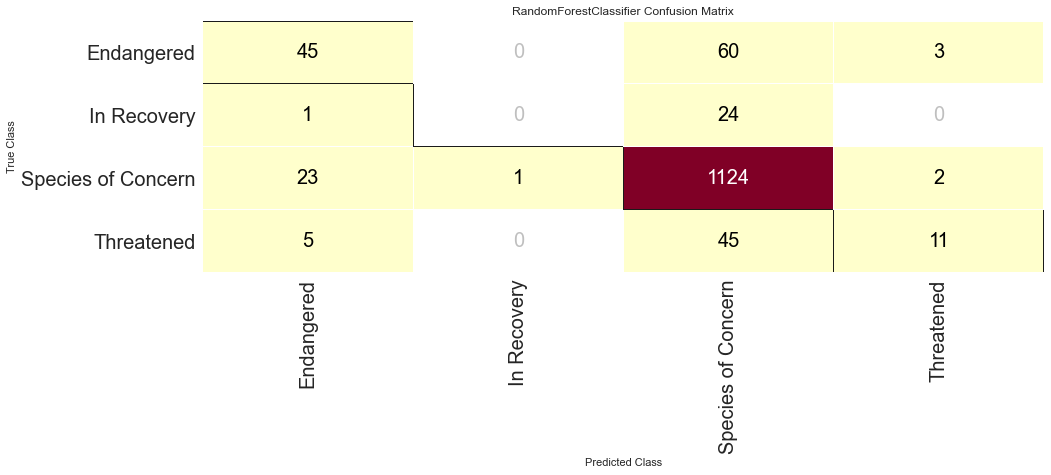

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [248]:
model = RandomForestClassifier(n_estimators = 1000, random_state = 42, bootstrap = True)

# Taxing model with confushion matrix
classes = ["Endangered", "In Recovery", "Species of Concern", "Threatened"]
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fitting the random forest model
cm.fit(X_train, y_train)

# Entering test data into mix
cm.score(X_val, y_val)

# Changing font size
for label in cm.ax.texts:
    label.set_size(20)

cm.poof()

C:\Users\datre\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


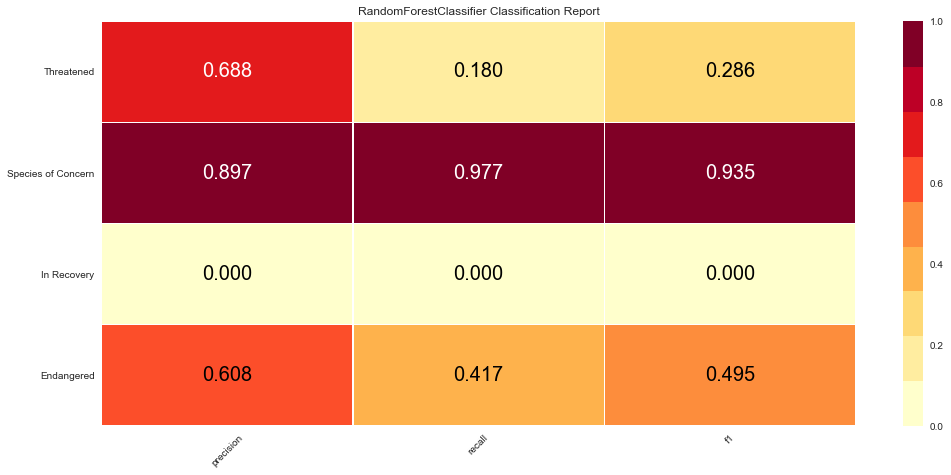

In [249]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

visualizer = ClassificationReport(model, classes=classes)

# Fitting training data to visualizer
visualizer.fit(X_train, y_train)
# Entering test data to model
visualizer.score(X_val, y_val) 

g = visualizer.poof()

C:\Users\datre\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


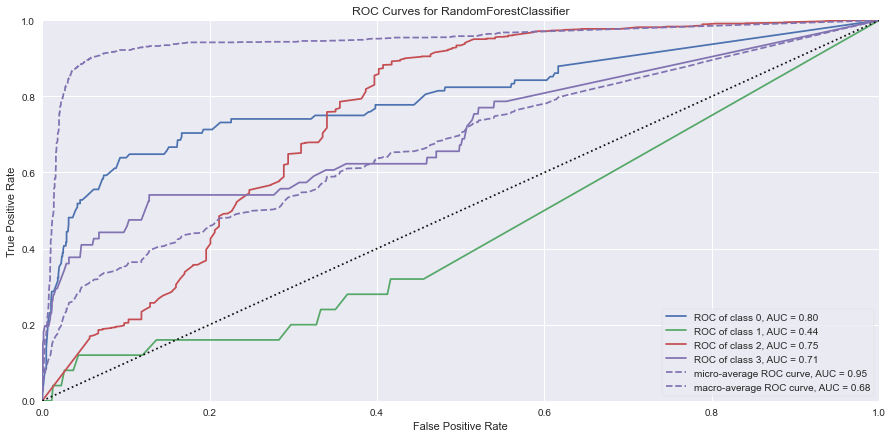

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [250]:
visualizer = ROCAUC(model)

# Fitting training data to visualizer
visualizer.fit(X_train, y_train)
# Entering test data to model
visualizer.score(X_val, y_val) 

visualizer.show()

#### Using Random Search for hyperparameter tuning

In [251]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [87]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [88]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [89]:
# Asking for best parameters from random search
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

#### Using Grid Search for hyperparameter tuning

In [92]:
# creating grid of hyperparameters based off random grid
param_grid = {
    "bootstrap": [False],
    "max_depth": [20, 30, 40, 50, 60],
    "max_features": ["sqrt"],
    "min_samples_split": [2, 4, 6, 8],
    "n_estimators": [200, 400, 600, 800, 1000]
}

In [93]:
rf = RandomForestClassifier()

In [94]:
# using Grid Search to narrow best hyperparameters
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.8min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': [20, 30, 40, 50, 60],
                         'max_features': ['sqrt'],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [200, 400, 600, 800, 1000]},
             verbose=2)

In [95]:
# Asking for best parameters found in grid search
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_split': 8,
 'n_estimators': 800}

#### Running Random Forest with tuned hyperparameters

In [245]:
# Creating tuned classifier using hyperparameters from grid search
rf_tuned = RandomForestClassifier(n_estimators = 800, min_samples_split = 8, max_features = "sqrt", max_depth = 20, bootstrap = False)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=20, max_features='sqrt',
                       min_samples_split=8, n_estimators=800)

In [246]:
# Creating new predictions
y_pred2 = rf_tuned.predict(X_val)

In [247]:
# Printing resulting information before visualization
print(confusion_matrix(y_val,y_pred2))
print(classification_report(y_val,y_pred2))
print(accuracy_score(y_val, y_pred2))

[[  40    0   63    5]
 [   1    0   24    0]
 [  23    1 1124    2]
 [   4    0   45   12]]
              precision    recall  f1-score   support

           0       0.59      0.37      0.45       108
           1       0.00      0.00      0.00        25
           2       0.89      0.98      0.93      1150
           3       0.63      0.20      0.30        61

    accuracy                           0.88      1344
   macro avg       0.53      0.39      0.42      1344
weighted avg       0.84      0.88      0.85      1344

0.875


The accuracy dropped slightly from 87.79% to 87.5%

C:\Users\datre\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


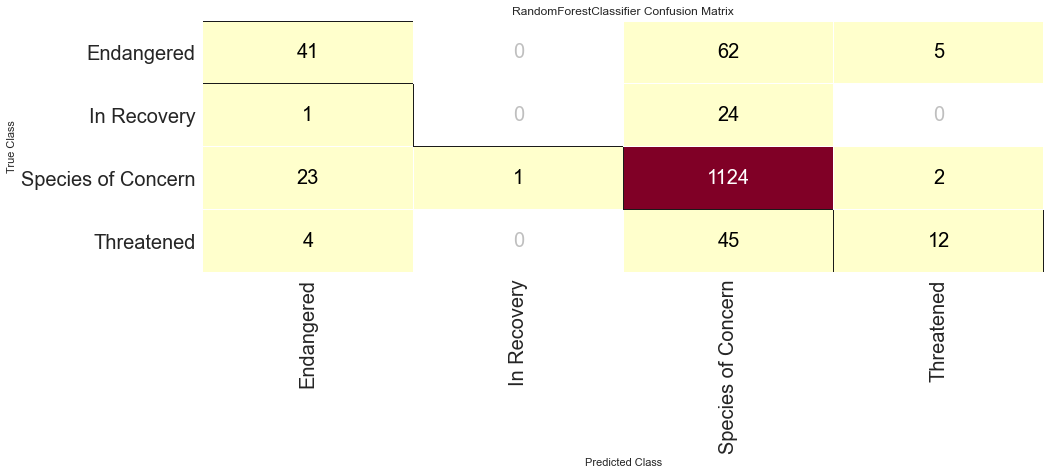

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [179]:
# Taxing model with confushion matrix
classes = ["Endangered", "In Recovery", "Species of Concern", "Threatened"]
cm = ConfusionMatrix(rf_tuned, classes=classes, percent=False)

# Fitting the random forest model
cm.fit(X_train, y_train)

# Entering test data into mix
cm.score(X_val, y_val)

# Changing font size
for label in cm.ax.texts:
    label.set_size(20)

cm.poof()

C:\Users\datre\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


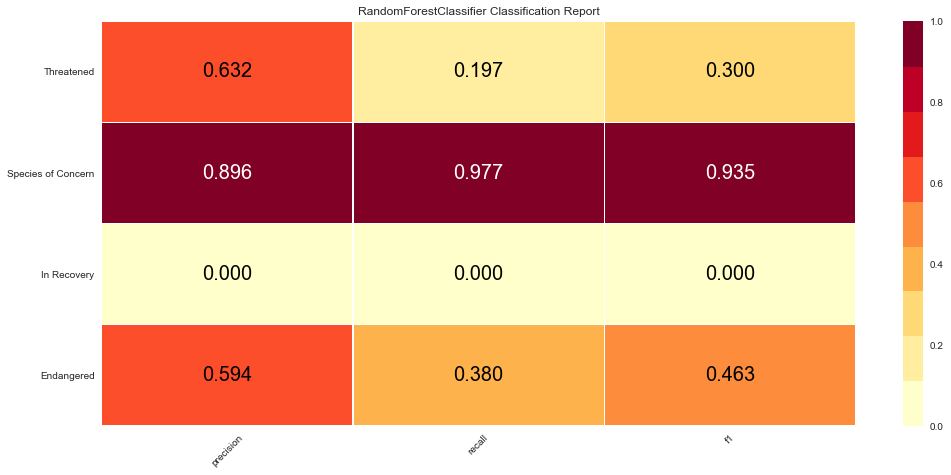

In [180]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

visualizer = ClassificationReport(rf_tuned, classes=classes)

# Fitting training data to visualizer
visualizer.fit(X_train, y_train)
# Entering test data to model
visualizer.score(X_val, y_val) 

g = visualizer.poof()

C:\Users\datre\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


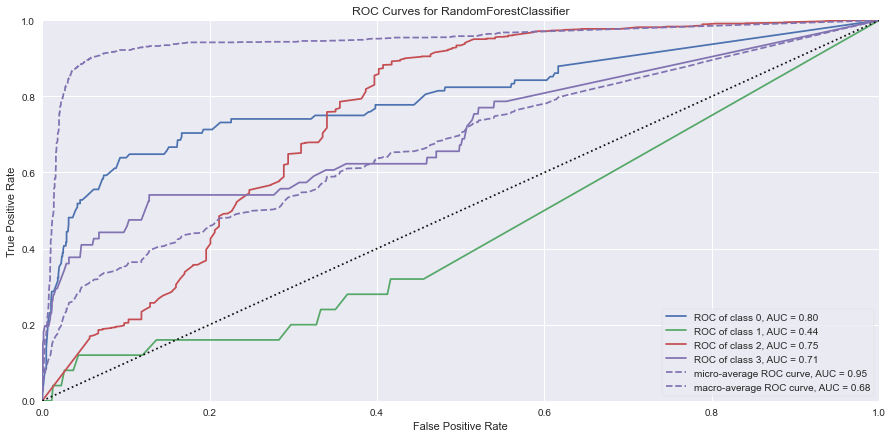

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [181]:
visualizer = ROCAUC(model)

# Fitting training data to visualizer
visualizer.fit(X_train, y_train)
# Entering test data to model
visualizer.score(X_val, y_val) 

g = visualizer.poof()
g

The hypertuning did help in the endangered category but reduced scores in the threatened category

#### Separating by Category

In [281]:
sp_category = sp.copy()
pd.crosstab(sp_category["Category"], sp_category["Conservation Status"])

Conservation Status,Endangered,In Recovery,Species of Concern,Threatened
Category,,,,
Amphibian,5,0,61,8
Bird,64,65,2371,51
Crab/Lobster/Shrimp,1,0,0,0
Fish,33,0,66,40
Fungi,1,0,2,0
Insect,17,0,107,4
Invertebrate,9,0,1,7
Mammal,93,9,552,19
Nonvascular Plant,0,0,27,0


In [284]:
chi2_contingency(pd.crosstab(sp_category["Category"], sp_category["Conservation Status"]))

(746.447405976747,
 1.269410315755824e-133,
 36,
 array([[6.18043770e+00, 1.27244305e+00, 6.35064761e+01, 3.04064314e+00],
        [2.13058062e+02, 4.38648950e+01, 2.18925703e+03, 1.04820009e+02],
        [8.35194283e-02, 1.71951764e-02, 8.58195623e-01, 4.10897722e-02],
        [1.16092005e+01, 2.39012952e+00, 1.19289192e+02, 5.71147834e+00],
        [2.50558285e-01, 5.15855293e-02, 2.57458687e+00, 1.23269317e-01],
        [1.06904868e+01, 2.20098258e+00, 1.09849040e+02, 5.25949084e+00],
        [1.41983028e+00, 2.92317999e-01, 1.45893256e+01, 6.98526128e-01],
        [5.62085753e+01, 1.15723537e+01, 5.77565654e+02, 2.76534167e+01],
        [2.25502456e+00, 4.64269763e-01, 2.31712818e+01, 1.10942385e+00],
        [1.11080840e+01, 2.28695846e+00, 1.14140018e+02, 5.46493971e+00],
        [2.25502456e+00, 4.64269763e-01, 2.31712818e+01, 1.10942385e+00],
        [8.35194283e-02, 1.71951764e-02, 8.58195623e-01, 4.10897722e-02],
        [5.87976775e+01, 1.21054042e+01, 6.04169719e+02, 2.8927

#### Separating by State

In [286]:
sp_state = sp.copy()
pd.crosstab(sp_state["State"], sp_state["Conservation Status"])

Conservation Status,Endangered,In Recovery,Species of Concern,Threatened
State,,,,
AK,31,2,263,14
AR,4,1,61,2
AZ,16,5,279,7
CA,67,20,627,31
"CA, NV",24,2,177,16
CO,10,4,261,7
FL,33,5,159,18
HI,84,0,103,8
KY,13,2,53,1


In [287]:
chi2_contingency(pd.crosstab(sp_state["State"], sp_state["Conservation Status"]))

(474.04294821280064,
 4.589547088753656e-58,
 78,
 array([[ 25.89102278,   5.33050469, 266.04064314,  12.73782939],
        [  5.67932113,   1.169272  ,  58.35730237,   2.79410451],
        [ 25.64046449,   5.27891916, 263.46605628,  12.61456007],
        [ 62.2219741 ,  12.81040643, 639.35573917,  30.6118803 ],
        [ 18.2907548 ,   3.76574364, 187.94484145,   8.99866012],
        [ 23.55247879,   4.84903975, 242.0111657 ,  11.58731577],
        [ 17.95667709,   3.69696293, 184.51205895,   8.83430103],
        [ 16.28628852,   3.3530594 , 167.34814649,   8.01250558],
        [  5.76284055,   1.18646717,  59.21549799,   2.83519428],
        [  5.92987941,   1.22085753,  60.93188924,   2.91737383],
        [  5.26172398,   1.08329611,  54.06632425,   2.58865565],
        [  4.67708799,   0.96292988,  48.05895489,   2.30102724],
        [  6.59803484,   1.35841894,  67.79745422,   3.24609201],
        [  4.51004913,   0.92853953,  46.34256364,   2.2188477 ],
        [  8.43546226,   1